[View in Colaboratory](https://colab.research.google.com/github/sin2akshay/External-Internship-Program-2.0-Machine-Learning-for-Deep-Neural-Networks/blob/master/Session%204/DNST_CIFAR10_AUG.ipynb)

In [0]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

**As is good practice, we next initialize the random number seed with a constant to ensure the results are reproducible.**

In [0]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 50
l = 40
num_filter = 64
compression = 0.5
dropout_rate = 0.2

In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoding 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 8s 0us/step


**Running the code below creates a 3×3 plot of photographs. The images have been scaled up from their small 32×32 size, but you can clearly see trucks horses and cars. You can also see some distortion in some images that have been forced to the square aspect ratio.**

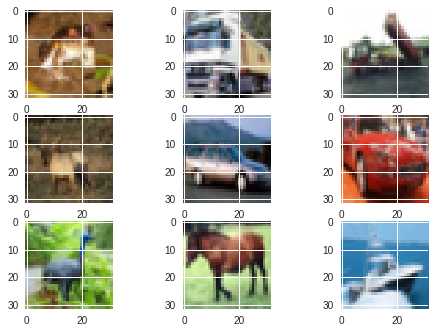

In [0]:
from matplotlib import pyplot
from scipy.misc import toimage

# create a grid of 3x3 images
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(toimage(x_train[i]))
# show the plot
pyplot.show()

## Converting the 32x32x3 images to 24x24x3

In [0]:
x_train_24 = []
x_test_24 = []

for img in x_train:
  x_train_24.append(np.resize(img,(24,24,3)))
  
for img in x_test:
  x_test_24.append(np.resize(img,(24,24,3)))

x_train_24 = np.array(x_train_24)
x_test_24 = np.array(x_test_24)
print(x_train_24[0].shape)

In [0]:
# create a grid of 3x3 images
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(toimage(x_train_24[i]))
# show the plot
pyplot.show()

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

##We will create a separate network model to process the 24x24 images:

In [0]:
num_filter = 64
dropout_rate = 0.3
l = 12
input = Input(shape=(24, 24, 3))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

##Train the model for 24x24x3 images for 15 epochs

In [0]:
#trying to fit a model for small image size
model.fit(x_train_24, y_train,
                    batch_size=64,
                    epochs=15,
                    verbose=1,
                    validation_data=(x_test_24, y_test))

In [0]:

# Test the model# Test t 
score = model.evaluate(x_test_24, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
validation_split=0.0)

In [0]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 12)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

ImportError: ignored

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer= 'sgd',
              metrics=['accuracy'])

In [0]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 114s 2ms/step - loss: 2.2379 - acc: 0.1646 - val_loss: 2.1012 - val_acc: 0.2435
Epoch 2/50
50000/50000 [==============================] - 102s 2ms/step - loss: 1.9039 - acc: 0.2839 - val_loss: 2.0154 - val_acc: 0.2743
Epoch 3/50
50000/50000 [==============================] - 102s 2ms/step - loss: 1.7711 - acc: 0.3290 - val_loss: 2.3981 - val_acc: 0.2297
Epoch 4/50
50000/50000 [==============================] - 102s 2ms/step - loss: 1.6876 - acc: 0.3617 - val_loss: 2.0810 - val_acc: 0.2850
Epoch 5/50
50000/50000 [==============================] - 102s 2ms/step - loss: 1.6164 - acc: 0.3923 - val_loss: 1.9430 - val_acc: 0.3220
Epoch 6/50
49920/50000 [============================>.] - ETA: 0s - loss: 1.5569 - acc: 0.4162

KeyboardInterrupt: ignored

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

In [0]:
from google.colab import files

files.download('DNST_model.h5')